# Simulating structurally variable NPCs for SMLM 
This Jupyter-Lab contains all relevant information to simulate variable NPCs and export them as CSV

## General notes for not-yet programmers: 
This notebook is mainly written in python. It does load or export things that are not python, though: 
A config.yaml file contains standard parameters that are translated to python, and may be modified if needed using python syntax. 
"null" in the .yaml file does not mean 0, but is equivalent to python "None": this value will be ignored in this framework. 

### Commenting/Uncommenting: 
A comment in python is, amongst other things, any content preceded by a "#". "Uncomment" means to remove the first "#"  


## Import relevant packages

In [1]:
import exportCSV #exports data and metadata
import NPC 
import NPC_plotting
import json
import numpy as np

In [2]:
%matplotlib widget 

## Specify directory in which to export data
Tip: It is good practice for the output directory to be distinct from the directory this jupyter-lab lives in 
Filepaths use backslashes "\\" on windows and forward slashes "/" on Mac or Linux 

In [3]:
data_dir = '/home/maria/Documents/NPCPython/deletemedata2/' # Directory for output files

## Select config file for simulation settings

In [4]:
config = 'config.yaml'

The config file is now transformed into a python dictionary called "var" (Short for variables).  
Any entry in var can be edited, and new entries can be added. var tells the simulator which properties the simulated NPCs should have.  
Entries in var are accessed or modified via a dictionary lookup with the following general notation:  
var["keyname"] = modified_value.  
Let's have a look at what's in var right now:  

In [5]:
var = NPC.getVars(config) # Transform config file into a python dictionary 
print(json.dumps(var, indent = 4)) # Print var in an easily readable format 

{
    "rel": false,
    "rvar": {
        "rnew": null,
        "rsigma": null
    },
    "thetavar": {
        "thetanew": null,
        "thetasigma": null
    },
    "dvar": {
        "dnew": null,
        "dsigma": null
    },
    "symmet": 8,
    "kappa": null,
    "shiftsigma": null,
    "elliptvar": {
        "elliptnew": null,
        "elliptsigma": null
    },
    "mag": 0,
    "zmag": 0,
    "sigmamult": 0.5,
    "nConnect": 2,
    "damp": 1,
    "kr": 0.7,
    "tlast": 20,
    "step": 0.25
}


## Inspect simulation variables from config.yaml before editing its entries
**rel**: relevant for multicolour simulations.  
If true, it selects the first listed nup as a reference to make it comparable to single-channel simulations of this nup. 
default is **false**  
**rvar**: radius variability  
**thetavar**: variability of twist angle between Nucleoplasmic and Cytoplasmic side  
**dvar**: variability of distance between Nucleoplasmic and Cyotplasmic side  
**elliptvar**: variability of ellipticity

**rvar**, **thetavar**, **dvar**, and **elliptvar** consists of two parameters, one indicating the mean value,  
the other the standard devation from this mean. Both are default **null** meaning these geometric parameters are not not changed from default values

**symmet**: Rotational symmetry of the NPC, default **8**  
**kappa**: Random independent tilt of Nucleoplasmic and Cytoplasmic side. Default **null** means no tilt.  
kappa=0 is random uniform tilt. The higher kappa, the less tilt from the default position is applied.  
**shiftsigma**: x and y offset of either Nucleoplasmic and Cytoplasmic side are independently sampled from a normal distribition with sigma = shiftsigma [nm]

# Update simulation variables

## Number of NPCs to be simulated
**NPCi** is the index out of NPC to be shown in any detail-plot or animation. The first NPC is indexed with 0, the last NPC with n-1. NPCi is not stored in var.  
**var["seed"]** sets a random seed for reproducibility. Choose any number but 0. Simulated NPCs with the same parameters and same random seed will always look the same  
set **var["seed"] = False** to simulate different NPCs for every run

In [6]:
var["n"] = 1000 # Number of NPCs to be simulated
NPCi = 0 # index out of n of NPC to be shown in any detail-plot or animation. 0-indexed.  
var["seed"] = 51234 #seed for reproducibility. Any number but 0

## Select one or more nups, their terminus, and an NPC model for simulation 

## List of all available models 
Click on the blue vertical bar to the left of the cell below to show/hide the table of model info

| Model                       | Substructure   | Origin                           | Resolution* $\overset{\circ}{A}$ |   |
|-----------------------------|----------------|----------------------------------|---------------------------|---|
| 5A9Q<sup>1</sup>    | ORs            | HeLa, isolated NE                | 23                        |   |
| 7PEQ<sup>2</sup>    | ORs            | DLD-1, native environment        | 35                        |   |
| 5IJN<sup>3</sup>    | IR             | HeLa, isolated NE                | 21.4                      |   |
| 5IJO<sup>3</sup>    | IR             | HeLa, isolated NE                | 21.4                      |   |
| 7PER<sup>2</sup>    | IR             | DLD-1, native environment        | 35                        |   |
| 7R5K<sup>4</sup> | Whole scaffold | HeLa, isolated NE                | 12                        |
| 7R5J<sup>4</sup> | Whole scaffold | HeLa, HEK293, native environment | 50                        |

*: As reported in PDB  
1: von Appen, Alexander et al. “In situ structural analysis of the human nuclear pore complex.” Nature vol. 526,7571 (2015): 140-143. doi:10.1038/nature15381  
2: Schuller, Anthony P et al. “The cellular environment shapes the nuclear pore complex architecture.” Nature vol. 598,7882 (2021): 667-671. doi:10.1038/s41586-021-03985-3  
3: Kosinski, Jan et al. “Molecular architecture of the inner ring scaffold of the human nuclear pore complex.” Science (New York, N.Y.) vol. 352,6283 (2016): 363-5. doi:10.1126/science.aaf0643  
4: Mosalaganti, Shyamal et al. “AI-based structure prediction empowers integrative structural analysis of human nuclear pores.” Science (New York, N.Y.) vol. 376,6598 (2022): eabm9506. doi:10.1126/science.abm9506  

## List of all selectable nups
Click on the blue vertical bar to the left of the cell below to show/hide full table of nup info

| Model                                            | Nup             | N-term. | C-term.                            | n in CR | NR | IR | bridge | total |
|--------------------------------------------------|-----------------|---------|------------------------------------|---------|----|----|--------|-------|
| 5A9Q                                             | Nup43            | 4      | 380                                | 2       | 2  |    |        | 4     |
|                                                  | Nup160          | 41      | 1201                               | 2       | 2  |    |        | 4     |
|                                                  | Nup37           | 9       | 326                                | 2       | 2  |    |        | 4     |
|                                                  | Sec13           | 14      | 304                                | 2       | 2  |    |        | 4     |
|                                                  | Seh1            | 1       | 322                                | 2       | 2  |    |        | 4     |
|                                                  | Nup85           | 9       | 475                                | 2       | 2  |    |        | 4     |
|                                                  | Nup155          | 20      | 730                                |         |    |    | 2      | 2     |
|                                                  | Nup133          | 518     | 1156                               | 2       | 2  |    |        | 4     |
|                                                  | Nup96           | 277     | 751                                | 2       | 2  |    |        | 4     |
|                                                  | Nup107          | 150     | 924                                | 2       | 2  |    |        | 4     |
| 7PEQ                                             | Nup133          | 518     | 1156                               | 2       | 2  |    |        | 4     |
|                                                  | Nup107          | 150     | 924                                | 2       | 2  |    |        | 4     |
|                                                  | Nup96           | 333     | 922                                | 2       | 2  |    |        | 4     |
|                                                  | Sec13           | 14      | 304                                | 2       | 2  |    |        | 4     |
|                                                  | Seh1            | 5       | 320                                | 2       | 2  |    |        | 4     |
|                                                  | Nup85           | 20      | 651                                | 2       | 2  |    |        | 4     |
|                                                  | Nup43           | 4       | 380                                | 2       | 2  |    |        | 4     |
|                                                  | Nup160          | 78      | 1195                               | 2       | 2  |    |        | 4     |
|                                                  | Nup37           | 18      | 324                                | 2       | 2  |    |        | 4     |
| 7PER                                             | Nup205          | 9       | 1692                               |         |    | 4  |        | 4     |
|                                                  | Nup155          | 20      | 1375                               |         |    | 4  |        | 4     |
|                                                  | Nup93           | 173     | 815                                |         |    | 4  |        | 4     |
|                                                  | Nup54           | 128     | 493                                |         |    | 4  |        | 4     |
|                                                  | Nup58<sup>1</sup>| 248    | 418                                |         |    | 4  |        | 4     |
|                                                  | Nup62           | 334     | 502                                |         |    | 4  |        | 4     |
| 5IJN                                             | Nup205          | 9       | 1692                               |         |    | 4  |        | 4     |
|                                                  | Nup54           | 128     | 493                                |         |    | 4  |        | 4     |
|                                                  | Nup58           | 248     | 418                                |         |    | 4  |        | 4     |
|                                                  | Nup155          | 20      |  2 x 863                           |         |    | 4  |     2  | 6     |
|                                                  |                 |         | 4 x 1375                           |         |    |    |        |       | 
|                                                  | Nup93           | 1       | 815                                |         |    | 4  |        | 4     |
|                                                  | Nup62           | 334     | 502                                |         |    | 4  |        | 4     |
| 5IJO                                             | Nup54           | 128     | 493                                |         |    | 4  |        | 4     |
|                                                  | Nup188          | 1       | 1564                               |         |    | 2  |        | 2     |
|                                                  | Nup205          | 9       | 1692                               |         |    | 2  |        | 2     |
|                                                  | Nup155          | 20      |  2 x 863                           |         |    | 4  |     2  | 6     |
|                                                  |                 |         | 4 x 1375                           |         |    |    |        |       | 
|                                                  | Nup93           | 1       | 815                                |         |    | 4  |        | 4     |
|                                                  | Nup58<sup>1</sup>  | 248     | 418                                |         |    | 4  |        | 4     |
|                                                  | Nup62           | 334     | 502                                |         |    | 4  |        | 4     |
| 7R5J                                             |
|                                                  | Nup210<sup>2</sup> | 2       | 1832                               |         |    | 8  |        | 8     |
|                                                  | ALADIN          | 2       | 486                                |         |    | 2  |        | 2     |
|                                                  | Nup93           | 2       | 819                                |         |    | 4  |        | 4     |
|                                                  | Nup93           | 94      | 819                                | 2       | 1  |    |        | 3     |
|                                                  | Nup188          | 2       | 1749                               |         |    | 2  |        | 2     |
|                                                  | Nup205          | 2       | 2012                               | 2       | 1  | 2  |        | 5     |
|                                                  | Nup155          | 10      | 1391                               |         |    | 4  | 2      | 6     |
|                                                  | NDL1            | 2       | 674                                |         |    | 2  |        | 2     |
|                                                  | Nup35           | 86      | 326                                |         |    | 4  |        | 4     |
|                                                  | Nup54           | 111     | 493                                |         |    | 4  |        | 4     |
|                                                  | Nup58<sup>1</sup> | 246     | 418                                |         |    | 4  |        | 4     |
|                                                  | Nup62           | 332     | 502                                | 1       |    | 4  |        | 5     |
|                                                  | Nup133          | 71      | 1156                               | 2       | 2  |    |        | 4     |
|                                                  | Nup107          | 144     | 925                                | 2       | 2  |    |        | 4     |
|                                                  | Nup96           | 232     | 937                                | 2       | 2  |    |        | 4     |
|                                                  | SEC13           | 2       | 302                                | 2       | 2  |    |        | 4     |
|                                                  | SEH1            | 2       | 324                                | 2       | 2  |    |        | 4     |
|                                                  | Nup85           | 2       | 656                                | 2       | 2  |    |        | 4     |
|                                                  | Nup43           | 2       | 380                                | 2       | 2  |    |        | 4     |
|                                                  | Nup160          | 38      | 1436                               | 2       | 2  |    |        | 4     |
|                                                  | Nup37           | 5       | 326                                | 2       | 2  |    |        | 4     |
|                                                  | ELYS            | 2       | 1005                               |         | 2  |    |        | 2     |
|                                                  | Nup98           | 731     | 880                                |         | 1  |    |        | 1     |
|                                                  | Nup98           | 597     | 615                                | 2       |    | 4  |        | 6     |
|                                                  | Nup214          | 700     | 972                                | 1       |    |    |        | 1     |
|                                                  | Nup88           | 7       | 741                                | 1       |    |    |        | 1     |

1: Reported as p58/p45  
2: Primarily in Nuclear Envelope lumen



You can write one nup **var["nup"]**, e.g. nup107, either as ("nup107",) or as "nup107" --- capitalisation doesn't matter.   
protein termini are listed equivalently.  
Multiple nups must be listed as a tuple, for instance ("nup107", "nup96"), and protein termini must have the same order as their corresponding Nup.  
**var["nup"]** = ("nup107", "nup96") and  
**var["term"]** = ("C", "N")  
**var["model"]**  = "7r5j" for instance means:   
"nup107-C, and N-nup96 as presented in PDB model '7r5j' are selected as virtual sites to attach a label, for instance a fluorophore"

In [7]:
var["nup"] = ("nup107",)
var["term"] = ("C",)
var["model"] = "7r5J"
#var["rel"] = True # remove the "#" before var["rel"] = True to select the first nup as reference 

In [8]:
if type(var["nup"]) == str: var["nup"] = tuple([var["nup"]])
if type(var["term"]) == str: var["term"] = tuple(["term"])

# Simulate variability 
## Irregular variability 
**mag**: magnitude of deforming forces in x-y direction; the higher, the more deformed. recommended 0 - 20  
**zmag**: magnitude of deforming offsets in z direction; the higher, the more deformed. default mag/2. 

In [9]:
# # Variability parameters
var["mag"] = 20 # Magnitude of irregular variability. 0: No deformation, 15: Strong deformation
var["zmag"] = var["mag"]/2 # magnitude of offset in z. Not computed via springs 

### Irregular variability - advanced settings
Following parameters can be modified to change behaviour of deformations, however this is not recommended.  
**sigmamult**: controls correlation of forces, higher values result in more correlated forces, thus smoother deformations. default = 0.5.  
**nConnect**: Adjusts number of springs. Default: 2, i.e each node is connected to the two nearest neighbours in clockwise direction, and to the 2 nearest neighbours in anticlockwise direction.  
Uncomment the cell below to try this out. 

In [10]:
#var["sigmamult"] = 0.5
#var["nConnect"] = 2
#var["tlast"] = 20

## Geometric variability
## Geometric parameters in var
### radius variability  
- **rnew** new mean radius
- **rsigma** standard deviation of radius  
### variability of twist angle between Nucleoplasmic and Cytoplasmic side  
- **thetanew** new twist angle
- **thetasigma** standard deviation of twist angle
### variability of distance between Nucleoplasmic and Cyotplasmic side  
- **dnew** new mean distance
- **dsigma** standard deviation of distance 
### variability of ellipticity
- **elliptnew**  new mean input ellipticity as ratio of minor to major axis
- **elliptsigma**  standard deviation of ellipticity

### others
**symmet**: Rotational symmetry of the NPC, default **8**  
**kappa**: Random independent tilt of Nucleoplasmic and Cytoplasmic side. Default **null** means no tilt.  
kappa=0 is random uniform tilt. The higher kappa, the less tilt from the default position is applied.  
**shiftsigma**: x and y offset of either Nucleoplasmic and Cytoplasmic side are independently sampled from a normal distribition with sigma = shiftsigma [nm]


### Modify geometric variability 
EXAMPLE: Generate NPCs with radius varying by a standard deviation of 5 nm that are also have a slight tilt in their nucleoplasmic and cytoplasmic side 

In [11]:
var["rsigma"] = 5
var["kappa"] = 40

# Run simulations
NPC.getNPCs(var) simulates NPCs that vary as described in var.  
The output additionally contains metadata.  

WARNING: Tilts (see var["kappa"]) and shifts (see var["shiftsigma"]) of the Nucleoplasmic and Cytoplasmic side are not yet applied to data contained in NPCs.  
This will be done in a later step.  

## A note on time
Irregular shapes are computed by applying forces to a damped spring system, which will thus deform to a new equilibrium shape.  
NPCs therefore contains temporal information stored as timesteps: The first timestep is the model before deformation,  
the last step is the model at a new equilibrium shape. As super-resolution microscopy techniques typically lack the temporal resolution   
to access NPC dynamics, we are only interested in the model at the last timestep.  
The last timestep **var["tlast"]** is 20 by default, sufficient to accomodate deformations with typical settings. 
Higher values might increase compute time, lower values might not offer enough time for the model to equilibrate.  
However if a large number of NPCs (n >> 5000) are computed at low deformation magnitudes (var["mag"] < 5), it might be beneficial to reduce **var["tlast"]**. 
Further below we introduce visualisation functions to check whether NPCs were able to equilibrate. 

In [12]:
#var["tlast"] = 20
NPCs = NPC.getNPCs(var) # Dictionary of all simulated NPCs

/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale
/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale


In [13]:
#print(NPCs.keys()) 

## Extract coordinates from variable NPCs. 
NPC.getNPCcoords() extracts coordinates of the final deformed state of the model. var["kappa"] and var["shiftsigma"] is applied here if applicable. 
rows of NPCscoords are x, y, z, nup index, NPC index.  
nup index specifies the nup: Always 0 in single-channel simulations  
NPC index specifies the NPC out of n

In [14]:
NPCscoords = NPC.getNPCcoords(NPCs, var) 

In [15]:
print(NPCscoords)

[[ 4.10636885e+01  2.66222183e+01  5.56137611e+01  0.00000000e+00
   0.00000000e+00]
 [ 1.73240806e+01  5.98624851e+01  5.52055289e+01  0.00000000e+00
   0.00000000e+00]
 [-2.69623031e+01  5.91164989e+01  6.10436622e+01  0.00000000e+00
   0.00000000e+00]
 ...
 [-5.59919878e+01 -2.69819267e+01  5.79289135e+00  0.00000000e+00
   9.99000000e+02]
 [-2.14656375e+01 -5.47551705e+01  5.46692065e-01  0.00000000e+00
   9.99000000e+02]
 [ 2.08460237e+01 -4.55101895e+01 -1.05093122e+00  0.00000000e+00
   9.99000000e+02]]


## Arrange NPCs on a grid
NPCscoords contains relative coordinates, i.e. NPCs are more or less 0-centred. They would overlap if plotted. 
OffsetNPCs() arranges these NPCs on a grid using a given offset

In [16]:
offset = 1.5 * np.mean(NPCs["rexp"]) # set offset to 1.5 * the expected NPC radius 
OffsetNPCs = NPC_plotting.OffsetNPCs(NPCscoords, offset)

# Visualise Output
## Overview of all deformed NPCs

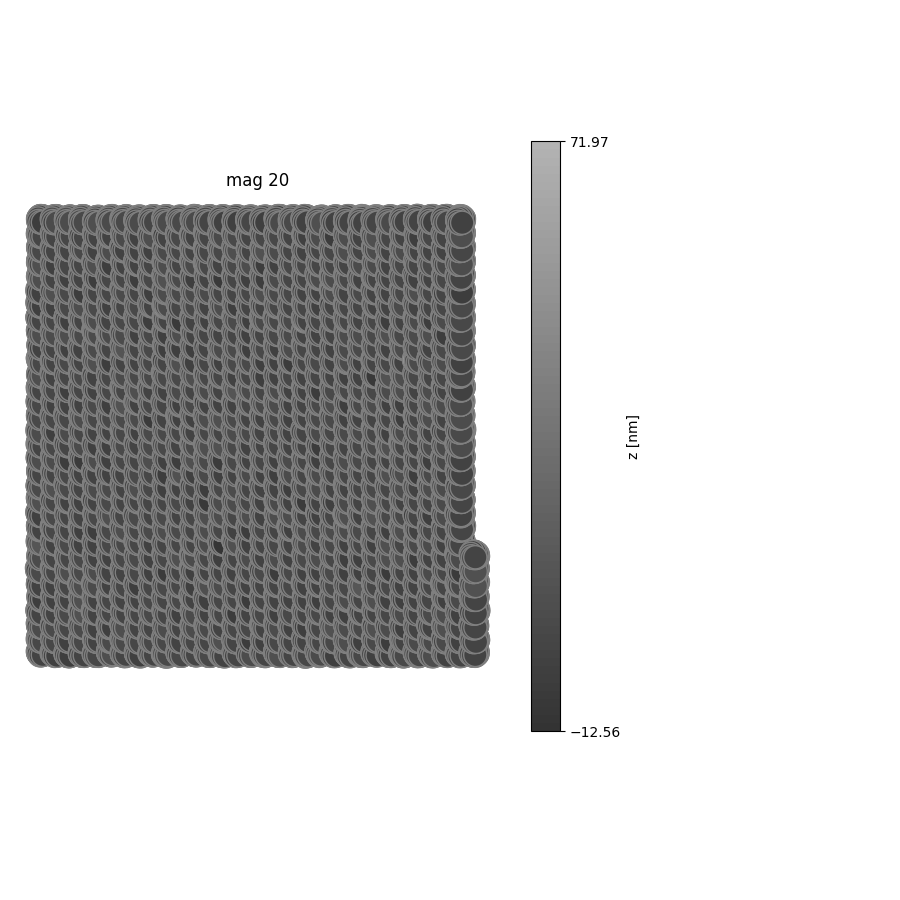

In [17]:
NPC_plotting.plotOverview(OffsetNPCs, NPCs, var, width = 9)

## Plot position of each nup over time for a given NPC
This allows to see whether all proteins of an NPC with index NPCi have reached a new equilibrium

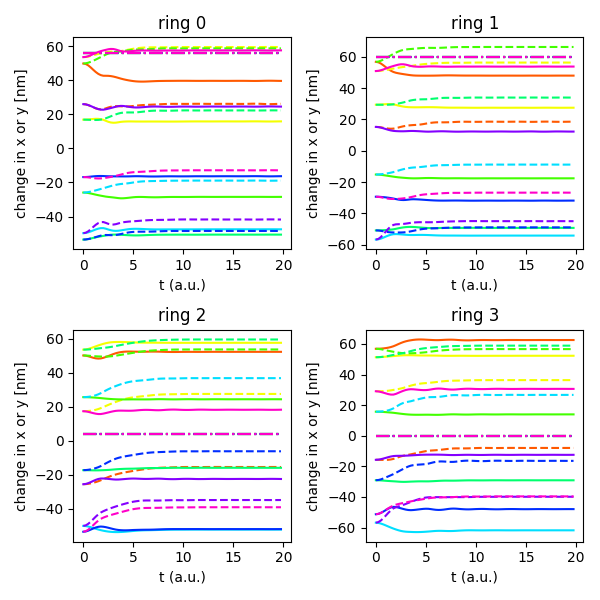

In [18]:
NPC_plotting.positionVStime(NPCs, NPCi, legend = True)

## Explore a specific NPC in greater detail 
Explore a specific NPC with index NPCi in greater detail, it can be plotted as a 2D or 3D plot.
3D plots are interactive - click and drag to view it from all angles. 

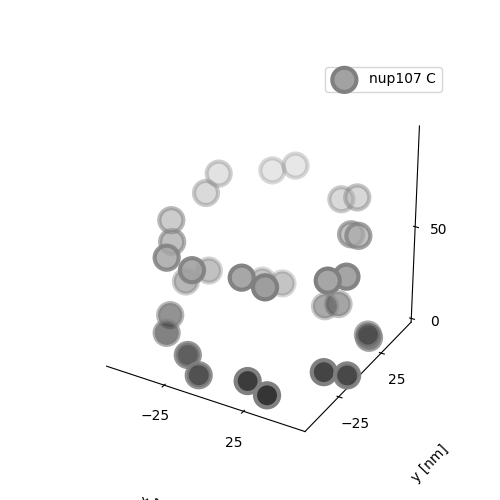

In [19]:
NPC_plotting.plotDetail(NPCscoords, NPCs, var, NPCi, width = 5, mode = "3D")

# Generate an animation of deformation 
## View deformation of an NPC with index NPCi in detail 

In [20]:
#NPC_plotting.AnimateDetail(NPCs, var, NPCi, width = 5, name = None)

## View deformations of all NPCs 
This is a great way to quickly check all NPCs have reached a new equlibrium. 
If this is not the case (unlikely for most standard parameters), the last timestep var["tlast"] can be adjusted before computing deformations (see further above). 

In [21]:
#NPC_plotting.AnimateOverview(NPCs, OffsetNPCs, var, width = 5, name = None)

# Export data

In [22]:
nameDict, name = exportCSV.names(var)
exportCSV.MakeCSV(var, NPCstest, NPCscoords, nameDict, name, data_dir) 

NameError: name 'NPCstest' is not defined